## 🔗 Open This Notebook in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DavidLangworthy/ds4s/blob/master/days/day05/starter/day05_starter.ipynb)

# 🌍 Day 5 – Capstone: CO₂ Emissions & Global Temperature
### Synthesizing multiple visuals into a climate narrative

Final day! You'll integrate emissions and temperature records, design a multi-panel figure, and practice the full storytelling workflow from claim to takeaway. Every panel has built-in checks so you can iterate confidently.

### Data card — CO₂ emissions + temperature anomalies
- **Sources:** [Our World in Data – Global CO₂ emissions](https://ourworldindata.org/co2-emissions) and [NASA GISTEMP temperature anomalies](https://data.giss.nasa.gov/gistemp)
- **Temporal coverage:** CO₂: 1750–2023; Temperature anomalies: 1880–present
- **Units:** CO₂ in billion tonnes (GtCO₂); temperature anomaly in °C relative to 1951–1980 baseline
- **Processing notes:** NASA file includes header rows and `***` placeholders for missing values; we reuse the tidy process from Day 1.
- **Caveats:** Emissions series excludes land-use change before 1850; early-year temperature data less certain. Align overlapping years before comparing.

### Preview: today's capstone figure
A three-panel visualization: (1) CO₂ trend, (2) temperature anomaly trend, (3) scatter linking the two, each with annotations and shared storytelling scaffold.

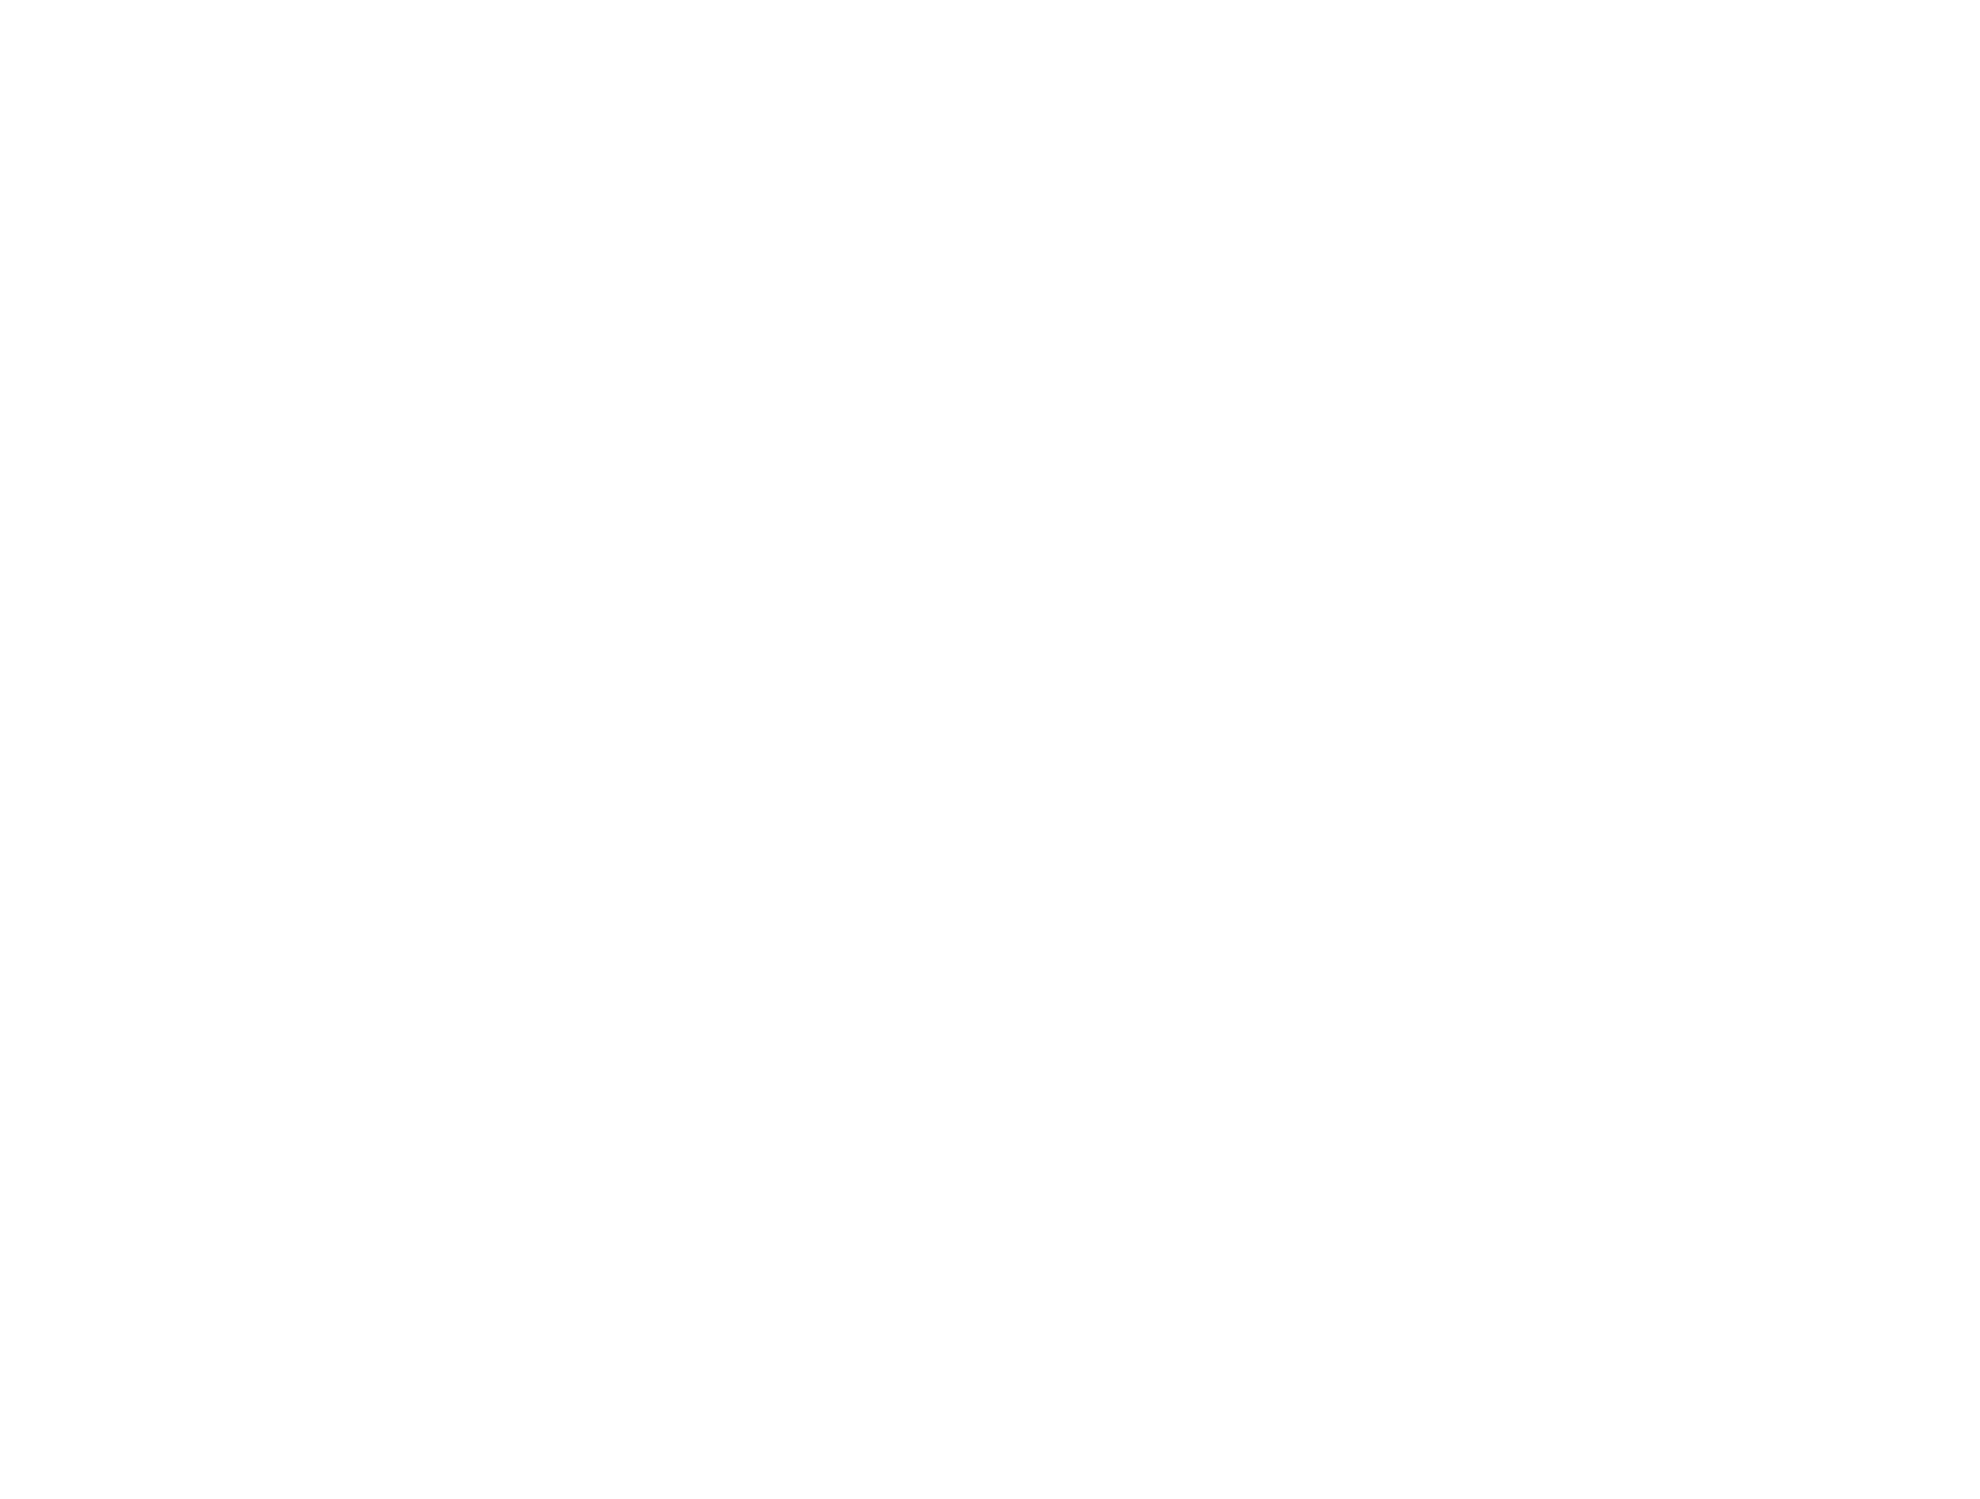

In [1]:
from pathlib import Path
from warnings import warn

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from IPython.display import Image, display

CANDIDATES = [Path.cwd(), *Path.cwd().parents]
for candidate in CANDIDATES:
    if (candidate / "data").exists():
        PROJECT_ROOT = candidate
        break
else:
    raise FileNotFoundError("Couldn't find the project root containing a data/ folder.")

DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_BASE = "https://raw.githubusercontent.com/DavidLangworthy/ds4s/master/data"
PLOTS_DIR = PROJECT_ROOT / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

COLORBLIND_FRIENDLY = ["#2E86AB", "#F18F01", "#A23B72", "#C73E1D", "#2EC4B6", "#33673B"]

if (PLOTS_DIR / "day05_solution_plot.png").exists():
    display(Image(filename=PLOTS_DIR / "day05_solution_plot.png", width=420))
else:
    print("Preview image not found; continue with the workflow.")


def load_data(csv_name: str, **read_kwargs) -> pd.DataFrame:
    path = DATA_DIR / csv_name
    if not path.exists():
        url = f"{RAW_DATA_BASE}/{csv_name}"
        print(f"Local file not found. Downloading {csv_name} from GitHub…")
        response = requests.get(url, timeout=30)
        try:
            response.raise_for_status()
        except requests.HTTPError as exc:
            raise FileNotFoundError(
                f"Could not retrieve {csv_name} from {url} (status {response.status_code})."
            ) from exc
        path.parent.mkdir(parents=True, exist_ok=True)
        path.write_bytes(response.content)
    df = pd.read_csv(path, **read_kwargs)
    print(f"Loaded {csv_name} → {df.shape[0]:,} rows × {df.shape[1]} columns.")
    return df

def validate_columns(df: pd.DataFrame, required: list[str]) -> None:
    missing = [col for col in required if col not in df.columns]
    if missing:
        warn(f"Missing columns: {missing}")
    else:
        print("✅ Columns look good:", required)


def expect_rows_between(df: pd.DataFrame, lower: int, upper: int) -> None:
    rows = len(df)
    if rows < lower or rows > upper:
        warn(f"Row count {rows:,} outside the expected range ({lower:,}–{upper:,}).")
    else:
        print(f"✅ Row count within expected range ({rows:,}).")


def quick_diagnostics(df: pd.DataFrame, name: str = "DataFrame") -> None:
    print(f"--- Quick check for {name} ---")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("Missing values:", df.isna().sum())
    display(df.head())


def check_story_fields(**fields) -> None:
    empty = [key for key, value in fields.items() if not str(value).strip()]
    if empty:
        warn(f"These storytelling fields still need text: {', '.join(empty)}")
    else:
        print("✅ Story scaffolding complete. Ready for the capstone plot!")


def baseline_style():
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams["axes.facecolor"] = "#F8FAFC"


def save_last_fig(filename: str) -> None:
    path = PLOTS_DIR / filename
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Figure saved to {path.relative_to(PROJECT_ROOT)}")


## Step 1. Load CO₂ emissions and temperature anomalies
We reuse the helper utilities from earlier days and perform immediate diagnostics.

In [2]:
co2 = load_data("global_co2.csv")
quick_diagnostics(co2.head(), name="CO2 preview")

temp_raw = load_data("GLB.Ts+dSST.csv", skiprows=1, na_values="***")
quick_diagnostics(temp_raw.head(), name="Temp raw preview")


Loaded global_co2.csv → 274 rows × 2 columns.
--- Quick check for CO2 preview ---
Shape: (5, 2)
Columns: ['Year', 'CO2']
Missing values: Year    0
CO2     0
dtype: int64


,Year,CO2
0,1750,9.306
1,1751,9.407
2,1752,9.505
3,1753,9.610
4,1754,9.734


Loaded GLB.Ts+dSST.csv → 146 rows × 19 columns.
--- Quick check for Temp raw preview ---
Shape: (5, 19)
Columns: ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'J-D', 'D-N', 'DJF', 'MAM', 'JJA', 'SON']
Missing values: Year    0
Jan     0
Feb     0
Mar     0
Apr     0
May     0
Jun     0
Jul     0
Aug     0
Sep     0
Oct     0
Nov     0
Dec     0
J-D     0
D-N     1
DJF     1
MAM     0
JJA     0
SON     0
dtype: int64


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.19,-0.25,-0.09,-0.17,-0.10,-0.21,-0.19,-0.11,-0.15,-0.24,-0.22,-0.18,-0.17,NaN,NaN,-0.12,-0.17,-0.20
1,1881,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.16,-0.22,-0.19,-0.07,-0.09,-0.10,-0.17,0.04,-0.08,-0.19
2,1882,0.16,0.13,0.04,-0.16,-0.14,-0.23,-0.17,-0.08,-0.15,-0.24,-0.17,-0.37,-0.11,-0.09,0.07,-0.09,-0.16,-0.19
3,1883,-0.29,-0.37,-0.12,-0.19,-0.18,-0.07,-0.08,-0.14,-0.22,-0.12,-0.24,-0.11,-0.18,-0.20,-0.34,-0.16,-0.10,-0.20
4,1884,-0.13,-0.08,-0.36,-0.40,-0.34,-0.35,-0.31,-0.28,-0.27,-0.25,-0.34,-0.31,-0.29,-0.27,-0.11,-0.37,-0.31,-0.29


✅ **Checkpoint:** CO₂ should include yearly totals in gigatonnes; the temperature dataset should match the structure from Day 1.

## Step 2. Tidy each dataset
Convert to numeric types, focus on overlapping years, and compute rolling context metrics.

In [3]:
co2["Year"] = co2["Year"].astype(int)
co2["CO2"] = co2["CO2"].astype(float)
co2_recent = co2.query("Year >= 1850").copy()
co2_recent["co2_5yr"] = co2_recent["CO2"].rolling(window=5, center=True).mean()

annual_temp = (
    temp_raw[["Year", "J-D"]]
    .rename(columns={"J-D": "anomaly_c"})
    .dropna()
)
annual_temp["Year"] = annual_temp["Year"].astype(int)
annual_temp["anomaly_c"] = pd.to_numeric(annual_temp["anomaly_c"], errors="coerce")
annual_temp = annual_temp.dropna()
annual_temp["anomaly_5yr"] = annual_temp["anomaly_c"].rolling(window=5, center=True).mean()

expect_rows_between(co2_recent, 150, 200)
expect_rows_between(annual_temp, 120, 200)
quick_diagnostics(co2_recent.tail(), name="Recent CO2")
quick_diagnostics(annual_temp.tail(), name="Recent temperature")


✅ Row count within expected range (174).
✅ Row count within expected range (145).
--- Quick check for Recent CO2 ---
Shape: (5, 3)
Columns: ['Year', 'CO2', 'co2_5yr']
Missing values: Year       0
CO2        0
co2_5yr    2
dtype: int64


,Year,CO2,co2_5yr
269,2019,37104.273,36388.5716
270,2020,35126.527,36649.3592
271,2021,36991.734,36861.5880
272,2022,37293.836,NaN
273,2023,37791.570,NaN


--- Quick check for Recent temperature ---
Shape: (5, 3)
Columns: ['Year', 'anomaly_c', 'anomaly_5yr']
Missing values: Year           0
anomaly_c      0
anomaly_5yr    2
dtype: int64


,Year,anomaly_c,anomaly_5yr
140,2020,1.01,0.916
141,2021,0.85,0.980
142,2022,0.89,1.042
143,2023,1.17,NaN
144,2024,1.29,NaN


### Mini self-diagnostic
If the rolling mean is `NaN` everywhere, check that you sorted by year before applying `rolling`.

## Step 3. Combine datasets for the scatter panel
We'll join on the overlapping year range and compute normalized series for annotation context.

In [4]:
combined = co2_recent.merge(annual_temp, on="Year", how="inner")

co2_baseline = combined["CO2"].iloc[0]
temp_baseline = combined["anomaly_c"].iloc[0]

combined = combined.assign(
    co2_index=lambda df: df["CO2"] / co2_baseline if co2_baseline else np.nan,
    temp_index=lambda df: df["anomaly_c"] / temp_baseline if temp_baseline else np.nan
)

quick_diagnostics(combined.tail(), name="Combined tail")
print("Combined range:", combined["Year"].min(), "to", combined["Year"].max())


--- Quick check for Combined tail ---
Shape: (5, 7)
Columns: ['Year', 'CO2', 'co2_5yr', 'anomaly_c', 'anomaly_5yr', 'co2_index', 'temp_index']
Missing values: Year           0
CO2            0
co2_5yr        2
anomaly_c      0
anomaly_5yr    1
co2_index      0
temp_index     0
dtype: int64


,Year,CO2,co2_5yr,anomaly_c,anomaly_5yr,co2_index,temp_index
139,2019,37104.273,36388.5716,0.98,0.922,43.242251,-5.764706
140,2020,35126.527,36649.3592,1.01,0.916,40.937336,-5.941176
141,2021,36991.734,36861.5880,0.85,0.980,43.111095,-5.000000
142,2022,37293.836,NaN,0.89,1.042,43.463173,-5.235294
143,2023,37791.570,NaN,1.17,NaN,44.043244,-6.882353


Combined range: 1880 to 2023


✅ **Expectation check:** The merged dataset should span 1880 onward with ~140 rows.

## Step 4. Craft the capstone story scaffold
Complete the Claim → Evidence → Visual → Takeaway strings before plotting.

In [5]:
TITLE = "Burning carbon has tracked a near-linear rise in global temperature"
SUBTITLE = "Global CO₂ emissions, temperature anomalies, and their relationship (1850–2023)"
ANNOTATION = "Emissions have quadrupled since 1950 while temperature anomalies climbed past 1.2 °C."
SOURCE = "Sources: Our World in Data (Global CO₂) & NASA GISTEMP"
UNITS = "Units: GtCO₂ per year; temperature anomaly (°C)"

check_story_fields(
    TITLE=TITLE,
    SUBTITLE=SUBTITLE,
    ANNOTATION=ANNOTATION,
    SOURCE=SOURCE,
    UNITS=UNITS,
)


✅ Story scaffolding complete. Ready for the capstone plot!


## Step 5. Assemble the multi-panel figure
We use Matplotlib's GridSpec to align three panels with a shared caption and annotations.

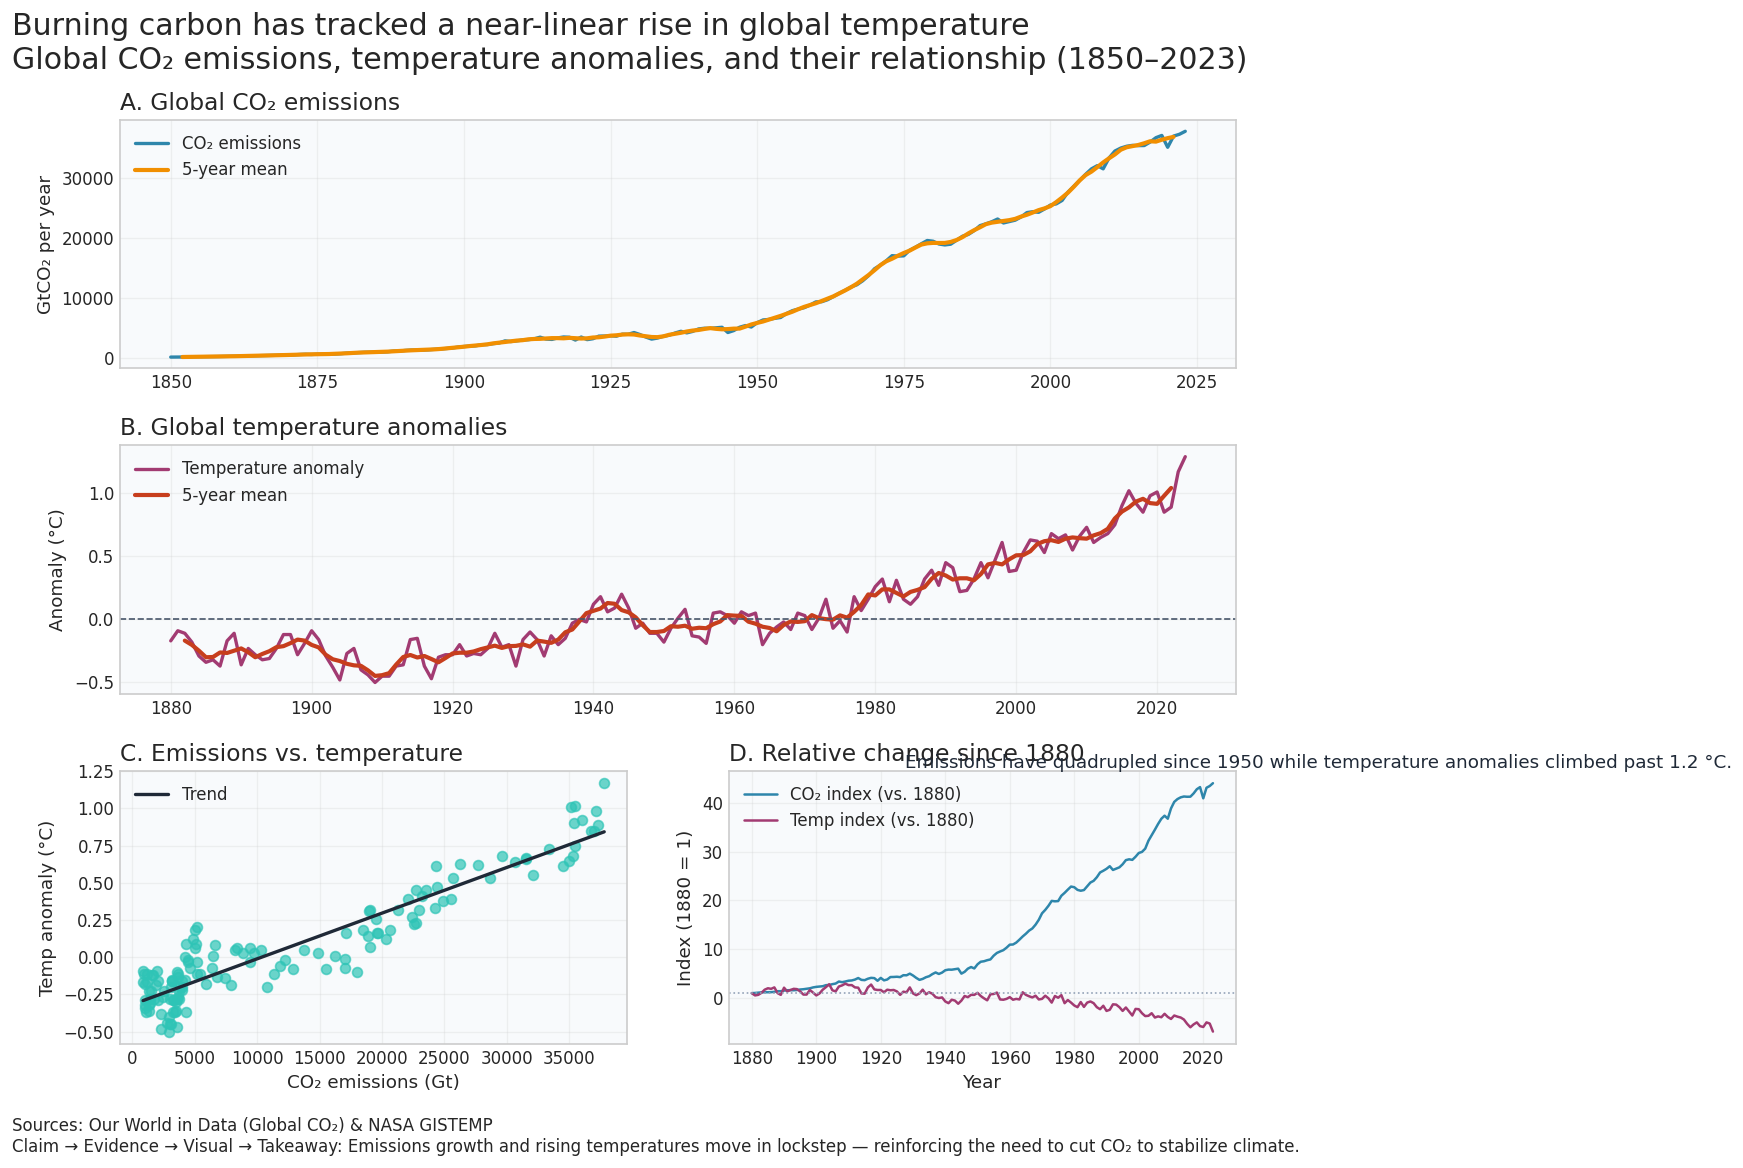

In [6]:
baseline_style()
fig = plt.figure(figsize=(12, 10))
from matplotlib.gridspec import GridSpec

gs = GridSpec(3, 2, height_ratios=[1, 1, 1.1], width_ratios=[1, 1], hspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(co2_recent["Year"], co2_recent["CO2"], color=COLORBLIND_FRIENDLY[0], linewidth=2, label="CO₂ emissions")
ax1.plot(co2_recent["Year"], co2_recent["co2_5yr"], color=COLORBLIND_FRIENDLY[1], linewidth=2.5, label="5-year mean")
ax1.set_ylabel("GtCO₂ per year")
ax1.set_title("A. Global CO₂ emissions", loc="left")
ax1.legend(frameon=False)

ax2 = fig.add_subplot(gs[1, :])
ax2.plot(annual_temp["Year"], annual_temp["anomaly_c"], color=COLORBLIND_FRIENDLY[2], linewidth=2, label="Temperature anomaly")
ax2.plot(annual_temp["Year"], annual_temp["anomaly_5yr"], color=COLORBLIND_FRIENDLY[3], linewidth=2.5, label="5-year mean")
ax2.axhline(0, color="#475569", linestyle="--", linewidth=1)
ax2.set_ylabel("Anomaly (°C)")
ax2.set_title("B. Global temperature anomalies", loc="left")
ax2.legend(frameon=False)

ax3 = fig.add_subplot(gs[2, 0])
ax3.scatter(combined["CO2"], combined["anomaly_c"], color=COLORBLIND_FRIENDLY[4], alpha=0.7, s=35)
coef = np.polyfit(combined["CO2"], combined["anomaly_c"], deg=1)
line_x = np.linspace(combined["CO2"].min(), combined["CO2"].max(), 200)
ax3.plot(line_x, np.polyval(coef, line_x), color="#1f2937", linewidth=2, label="Trend")
ax3.set_xlabel("CO₂ emissions (Gt)")
ax3.set_ylabel("Temp anomaly (°C)")
ax3.set_title("C. Emissions vs. temperature", loc="left")
ax3.legend(frameon=False)

ax4 = fig.add_subplot(gs[2, 1])
ax4.plot(combined["Year"], combined["co2_index"], label="CO₂ index (vs. 1880)", color=COLORBLIND_FRIENDLY[0])
ax4.plot(combined["Year"], combined["temp_index"], label="Temp index (vs. 1880)", color=COLORBLIND_FRIENDLY[2])
ax4.axhline(1, color="#94a3b8", linestyle=":", linewidth=1)
ax4.set_xlabel("Year")
ax4.set_ylabel("Index (1880 = 1)")
ax4.set_title("D. Relative change since 1880", loc="left")
ax4.legend(frameon=False)

title_text = TITLE + "\n" + SUBTITLE
fig.suptitle(title_text, x=0.05, y=0.97, ha="left", fontsize=18)
caption_text = SOURCE + "\n" + "Claim → Evidence → Visual → Takeaway: Emissions growth and rising temperatures move in lockstep — reinforcing the need to cut CO₂ to stabilize climate."
fig.text(0.05, 0.02, caption_text, fontsize=10, ha="left")
fig.text(0.67, 0.34, ANNOTATION, fontsize=11, color="#1f2937")
plt.show()


### Accessibility checklist
- Distinct, colorblind-safe palette across panels.
- Each axis labeled with units; scatter uses gridlines to aid interpretation.
- Caption consolidates sources and narrative.
- Annotation positioned to avoid overlapping data points.

In [7]:
save_last_fig("day05_solution_plot.png")


Figure saved to plots/day05_solution_plot.png


<Figure size 768x576 with 0 Axes>

## Step 6. Capstone reflection prompts
- What additional evidence (e.g., sea-level rise, extreme weather) would strengthen this story?
- How might you adapt the narrative for policymakers vs. general audiences?
- Which assumptions should be surfaced (data revisions, historical uncertainties, attribution science)?
- Encourage learners to outline their own Claim → Evidence → Visual → Takeaway for a new sustainability topic.